<a href="https://colab.research.google.com/github/zajacn/Qiime2_Tutorial_FGCZ/blob/main/02_16SVisualisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Qiime2 tutorial: Data visualisation and differential abundance analysis

This notebook processes QIIME2 output from Earth Microbiome Project. The Earth Microbiome project data is also used in the Moving Pictures tutorial (https://pubmed.ncbi.nlm.nih.gov/21624126/). The data is loaded using qiime2R R library and analysed using phyloseq R library. Differential abundance analysis is performed with ANCOMBC, Deseq2, EdgeR and Lefse (all using different R libraries). The notebook and corresponding setup script were adapted from the QIIME2 read processing tutorial.

Save your own local copy of this notebook by using File > Save a copy in Drive. At some point you may be prompted to trust the notebook. We promise that it is safe 🤞


## Setup
First we need to get the R library and the data.

In [ ]:
! git clone https://github.com/zajacn/Qiime2_Tutorial_FGCZ.git materials
! cd materials

Cloning into 'materials'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 33 (delta 2), reused 30 (delta 2), pack-reused 0
Receiving objects: 100% (33/33), 1.58 MiB | 15.54 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [ ]:
! wget -O library.tar.gz https://fgcz-gstore.uzh.ch/projects/p29925/library.tar.gz --user= --password=

--2023-11-24 12:45:53--  https://fgcz-gstore.uzh.ch/projects/p29925/library.tar.gz
Resolving fgcz-gstore.uzh.ch (fgcz-gstore.uzh.ch)... 130.60.193.36
Connecting to fgcz-gstore.uzh.ch (fgcz-gstore.uzh.ch)|130.60.193.36|:443... connected.
HTTP request sent, awaiting response... 401 Unauthorized
Authentication selected: Basic realm="FGCZ B-Fabric LDAP"
Reusing existing connection to fgcz-gstore.uzh.ch:443.
HTTP request sent, awaiting response... 200 OK
Length: 1146631680 (1.1G) [application/x-gzip]
Saving to: ‘library.tar.gz’

library.tar.gz      100%[===================>]   1.07G  26.1MB/s    in 43s     

2023-11-24 12:46:37 (25.4 MB/s) - ‘library.tar.gz’ saved [1146631680/1146631680]



In [ ]:
!tar xf library.tar.gz

tar: Removing leading `/' from member names


In [ ]:
# activate R magic
%load_ext rpy2.ipython

In [ ]:
%%R
.libPaths('usr/local/lib/R/site-library/')

In [ ]:
%%R
library(phyloseq)
library(dplyr)
library(tidyverse)
library(DESeq2)
library(edgeR)
library(ggplot2)
library(plotly)
library(ggrepel)
library(ggpubr)
library(grid)
library(gridExtra)
library(qiime2R)
library(reticulate)
library(patchwork)
library(cowplot)
library(scales)
library(kableExtra)
library(rstatix)
library(vegan)
library(pairwiseAdonis)
library(ggtreeExtra)
library(ggtree)
library(dplyr)
library(ggvenn)
library(microbiome)
library(RColorBrewer)
library(ComplexHeatmap)
library(DT)

Attaching package: ‘dplyr’



    filter, lag



    intersect, setdiff, setequal, union




── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.4
✔ ggplot2   3.4.4     ✔ stringr   1.5.0
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors





Attaching package: ‘BiocGenerics’



    intersect, setdiff, union



    combine, intersect, setdiff, union



    IQR, mad, sd, var, xtabs



    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Attaching package: ‘S4Vectors’



    second, second<-



    expand



    first, rename



    findMatches



    expand.grid, I, unname



Attaching package: ‘IRanges’



    %within%



    reduce



    collapse, desc, slice



    distance







Attaching package: ‘matrixStats’



    count


Attaching package: ‘MatrixGenerics’



    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumpro

In [ ]:
from rpy2.rinterface_lib.callbacks import logger as rpy2_logger
import logging
rpy2_logger.setLevel(logging.ERROR)

## Data preprocessing

In this section we:
- load our data as an RDS object
- load our QIIME2 reports
- filter our phyloseq object for ASVs present in at least 10% of the samples and with a count of at least 1
- transform our counts by dividing the counts for a particular ASV by the total counts
- agglomerate our data by Genus/ by Species

In [ ]:
%%R
getwd()

[1] "/content"


In [ ]:
%%R
##Load the data
physeq<-readRDS("dataset/physeq.rds")
#Filter samples: feature present in at least 10% of the samples
physeq_filter = genefilter_sample(physeq, filterfun_sample(function(x) x > 1), A=0.1*nsamples(physeq))
physeq1 = prune_taxa(physeq_filter, physeq)
#Transform sample counts
physeq2 = transform_sample_counts(physeq1, function(x){x / sum(x)})

#Aggregate by species and genus
physeq_Genus = tax_glom(physeq1, "Genus", NArm = TRUE)
physeq_Genus2 = transform_sample_counts(physeq_Genus, function(x){x / sum(x)})
physeq_Species = tax_glom(physeq1, "Species", NArm = TRUE)
physeq_Species2 = transform_sample_counts(physeq_Species, function(x){x / sum(x)})

dada2 <- readRDS("dataset/dada2.rds")
metadata<-readRDS("dataset/metadata.rds")
colnames(metadata) <- c("SampleID", "Group")
shannon<-readRDS("dataset/shannon.rds")
evenness<-readRDS("dataset/evenness.rds")
richness<-readRDS("dataset/richness.rds")
shannon<-shannon$data %>% rownames_to_column("SampleID")
richness<- richness$data %>% rownames_to_column("SampleID")
evenness<- evenness$data %>% rownames_to_column("SampleID")
jaccard<-readRDS("dataset/jaccard.rds")
jaccardmatrix <- readRDS("dataset/jaccardmatrix.rds")
jaccardmatrix <- as.matrix(jaccardmatrix$data)
bray<-readRDS("dataset/bray.rds")
braymatrix <- readRDS("dataset/braymatrix.rds")
braymatrix <- as.matrix(braymatrix$data)
unifrac <- readRDS("dataset/unifrac.rds")
unifracmatrix <- readRDS("dataset/unifracmatrix.rds")
unifracmatrix <- as.matrix(unifracmatrix$data)
ancombc <- readRDS("dataset/ancombc.rds")
lefse <- readRDS("dataset/lefse.rds")

#Define grouping parameter
params = readRDS("dataset/param.rds")
grouping <- "Group"



Error in gzfile(file, "rb") : cannot open the connection


Lets have a look at the metadata file: What samples are you looking at?

In [ ]:
%%R
metadata

   SampleID      Group
1    L1S105        gut
2    L1S140        gut
3    L1S208        gut
4    L1S257        gut
5    L1S281        gut
6     L1S57        gut
7     L1S76        gut
8      L1S8        gut
9    L2S155  left_palm
10   L2S175  left_palm
11   L2S204  left_palm
12   L2S222  left_palm
13   L2S240  left_palm
14   L2S309  left_palm
15   L2S357  left_palm
16   L2S382  left_palm
17   L3S242 right_palm
18   L3S294 right_palm
19   L3S313 right_palm
20   L3S341 right_palm
21   L3S360 right_palm
22   L3S378 right_palm
23   L4S112 right_palm
24   L4S137 right_palm
25    L4S63 right_palm
26   L5S104     tongue
27   L5S155     tongue
28   L5S174     tongue
29   L5S203     tongue
30   L5S222     tongue
31   L5S240     tongue
32    L6S20     tongue
33    L6S68     tongue
34    L6S93     tongue


## Demultiplexing summary

#### Read Frequency Histogram

Here is a histogram reflecting the distribution of the final number of filtered reads per sample.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


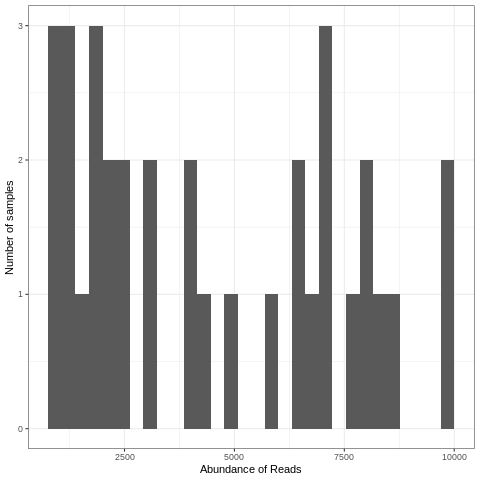

In [ ]:
%%R
ps0_tax_plot <- ggplot(dada2$data, aes(non.chimeric)) +
  geom_histogram() + theme_bw() + ylab("Number of samples") + xlab("Abundance of Reads")

print(ps0_tax_plot)

#### Read filtering.  
And here you can find the number of reads filtered at each stage and the final number of reads that remained after denoising.


In [ ]:
%%R
print(dada2$data)

       input filtered percentage.of.input.passed.filter denoised non.chimeric
L1S105 11340     8571                             75.58     8499         7780
L1S140  9738     7677                             78.84     7605         7163
L1S208 11337     9261                             81.69     9152         8152
L1S257  8216     6705                             81.61     6627         6388
L1S281  8907     7067                             79.34     6976         6615
L1S57  11752     9299                             79.13     9260         8702
L1S76  10101     8395                             83.11     8337         7867
L1S8   12388     7663                             61.86     7624         7033
L2S155  9263     4112                             44.39     3932         3932
L2S175 10692     4546                             42.52     4386         4386
L2S204  7299     3379                             46.29     3199         3158
L2S222  8386     3485                             41.56     3187

**QUESTION**

What is the sample with minimum/maximum number of reads?

A) "L4S63/L3S313"

B) "all samples have same number of reads"

C) "L3S341/L4S137"

D) "L1S76/L2S309"

**QUESTION**

What is the range of percentage of input reads that passed the quality filtering and chimera removal?"

A) "98.5-99.9%"

B) "2-100%"

C) "77.88-36.99%"

D) "50-100%"

## Abundance summary


### Filtering
The original analysis has been filtered and contains only Amplicon Sequence Variants that occur in at least 10% of samples and of at least a count of 1. Lets compare how many ASVs have remained after that filtering.
</br>

In [ ]:
%%R
knitr::knit_print(paste("Originally there were", length(rownames(otu_table(physeq))), "ASVs across", length(colnames(otu_table(physeq1))), "samples. "))
knitr::knit_print(paste("After filtering there are", length(rownames(otu_table(physeq1))), "ASVs across", length(colnames(otu_table(physeq1))), "samples."))


[1] "Originally there were 770 ASVs across 34 samples. "
[1] "After filtering there are 204 ASVs across 34 samples."


### Transformation
</br>
The counts are then transformed into relative abundance (number of reads per taxon divided by total number of reads). Lets have a look whether the transformation changed the abundance patters for selected genera (taking top 50 ASVs).

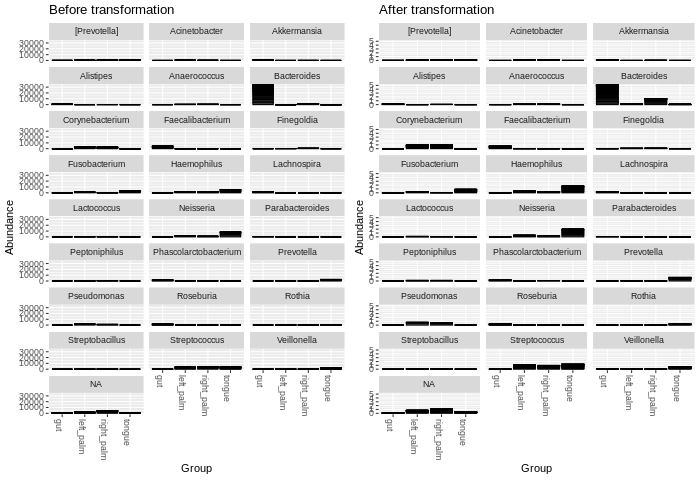

In [ ]:
%%R -w 700
myTaxa = names(sort(taxa_sums(physeq1), decreasing = TRUE)[1:50])
ex1 = prune_taxa(myTaxa, physeq1)
ex2 = prune_taxa(myTaxa, physeq2)
p1 <- plot_bar(ex1, "Group") + facet_wrap(~Genus, ncol=3) + ggtitle("Before transformation")
p2 <- plot_bar(ex2, "Group") + facet_wrap(~Genus, ncol=3) + ggtitle("After transformation")

plotGrob <- plot_grid(p1, p2, nrow=1, ncol=2, byrow=FALSE)
print(plot_grid(plotGrob, nrow=1, ncol=1, rel_heights=c(1, 15)))

### Taxa prevalence
</br>
Also lets look at the prevalence of different taxa before and after filtering. This function allows you to have an overview of ASV prevalences along with their taxonomic affiliations. It also gives an idea about the taxonomic affiliation of rare and abundant taxa in the data. This will aid in checking if you filter ASVs based on prevalence, then what taxonomic affiliations will be lost.

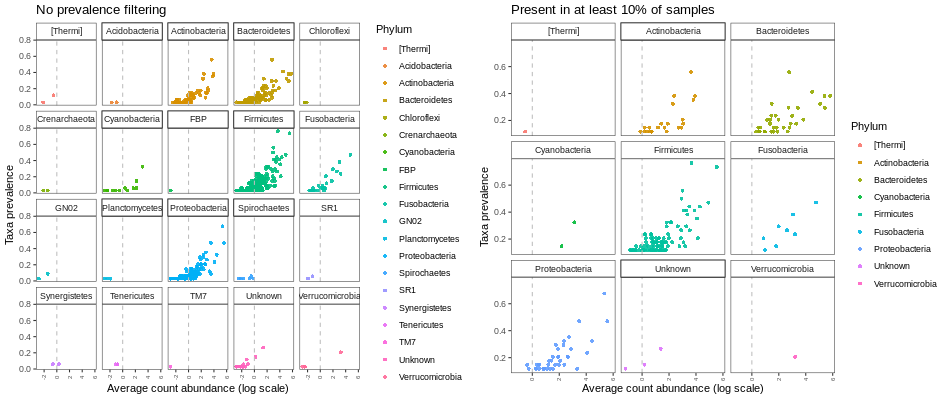

In [ ]:
%%R -w 950 -h 400 -u px
p1 <- plot_taxa_prevalence(physeq, "Phylum") + ggtitle("No prevalence filtering")
p2 <- plot_taxa_prevalence(physeq1, "Phylum") + ggtitle("Present in at least 10% of samples")

library("repr")
options(repr.plot.width=12.7, repr.plot.height=15)
plotGrob <- plot_grid(p1, p2, nrow=1, ncol=2, byrow=FALSE)
print(plotGrob)

### Heatmap of the top 30 features (ASVs).   

</br>
This heatmap displays the log10(% abundance) of the top 30 ASVs. Abundance is converted into percentage, a pseudocount is added and the data is log transformed. The top 30 most abundant ASVs are chosen to be displayed.
</br>


`summarise()` has grouped output by 'SampleID'. You can override using the
`.groups` argument.
Joining with `by = join_by(SampleID)`
Joining with `by = join_by(Feature.ID)`


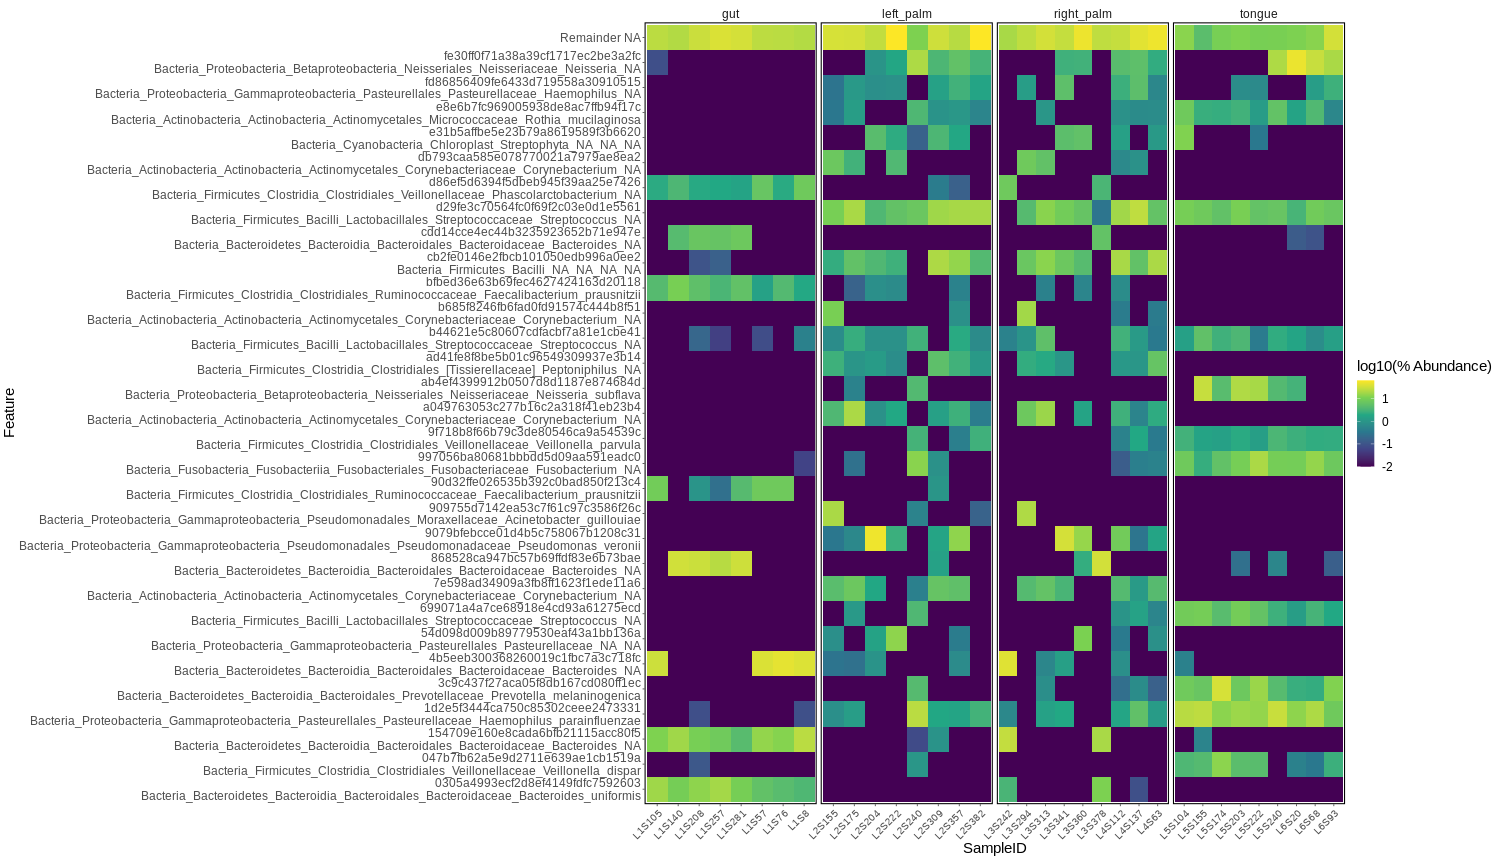

In [ ]:
%%R -w 1500 -h 860 -u px
SVs<-as.data.frame(otu_table(physeq1))
taxonomy<-as.data.frame(tax_table(physeq1))
taxonomy$Feature.ID <- rownames(taxonomy)
taxonomy$Taxon <- paste0(taxonomy$Kingdom, "_", taxonomy$Phylum, "_", taxonomy$Class, "_", taxonomy$Order, "_", taxonomy$Family, "_", taxonomy$Genus, "_", taxonomy$Species)
metadata$SampleID <- as.character(metadata$SampleID)

SVs<-apply(SVs, 2, function(x) x/sum(x)*100) #convert to percent

SVsToPlot<-
  data.frame(MeanAbundance=rowMeans(SVs)) %>% #find the average abundance of a SV
  rownames_to_column("Feature.ID") %>%
  arrange(desc(MeanAbundance)) %>%
  top_n(30, MeanAbundance) %>% #Use only top 30 taxa
  pull(Feature.ID) #extract only the names from the table

SV1 <- SVs %>%
  as.data.frame() %>%
  rownames_to_column("Feature.ID") %>%
  gather(-Feature.ID, key="SampleID", value="Abundance") %>%
  mutate(Feature.ID=if_else(Feature.ID %in% SVsToPlot,  Feature.ID, "Remainder")) %>% #flag features to be collapsed
  group_by(SampleID, Feature.ID) %>%
  summarize(Abundance=sum(Abundance)) %>%
  left_join(metadata) %>%
  mutate(NormAbundance=log10(Abundance+0.01)) %>% # do a log10 transformation after adding a 0.01% pseudocount. Could also add 1 read before transformation to percent
  left_join(taxonomy) %>%
  mutate(Feature=paste(Feature.ID, Taxon)) %>%
  mutate(Feature=gsub("[kpcofgs]__", "", Feature)) # trim out leading text from taxonomy string

SV1$Genus = str_remove_all(SV1$Genus,"[\\[\\]]")

p1 <- ggplot(SV1, aes(x=SampleID, y=Feature, fill=NormAbundance)) +
  geom_tile() +
  facet_grid(paste0('~', SV1[,grouping]), scales="free_x") +
  theme_q2r() +
  theme(axis.text.x=element_text(angle=45, hjust=1, size=10), text = element_text(size = 15)) +
  scale_y_discrete(labels = function(x) stringr::str_wrap(x, width = 55)) +
  scale_fill_viridis_c(name="log10(% Abundance)")

p1

### Heatmap at a Genus level.

</br>
Now let's create a separate Phyloseq object where the ASVs have all been agglomerated at genus level. This will reduce the number of ASVs further and then we can investigate the abundance of the different genra across all groups. The heatmap displays the log10(% abundance) of all the genra.


`summarise()` has grouped output by 'SampleID'. You can override using the
`.groups` argument.
Joining with `by = join_by(SampleID)`
Joining with `by = join_by(Feature.ID)`


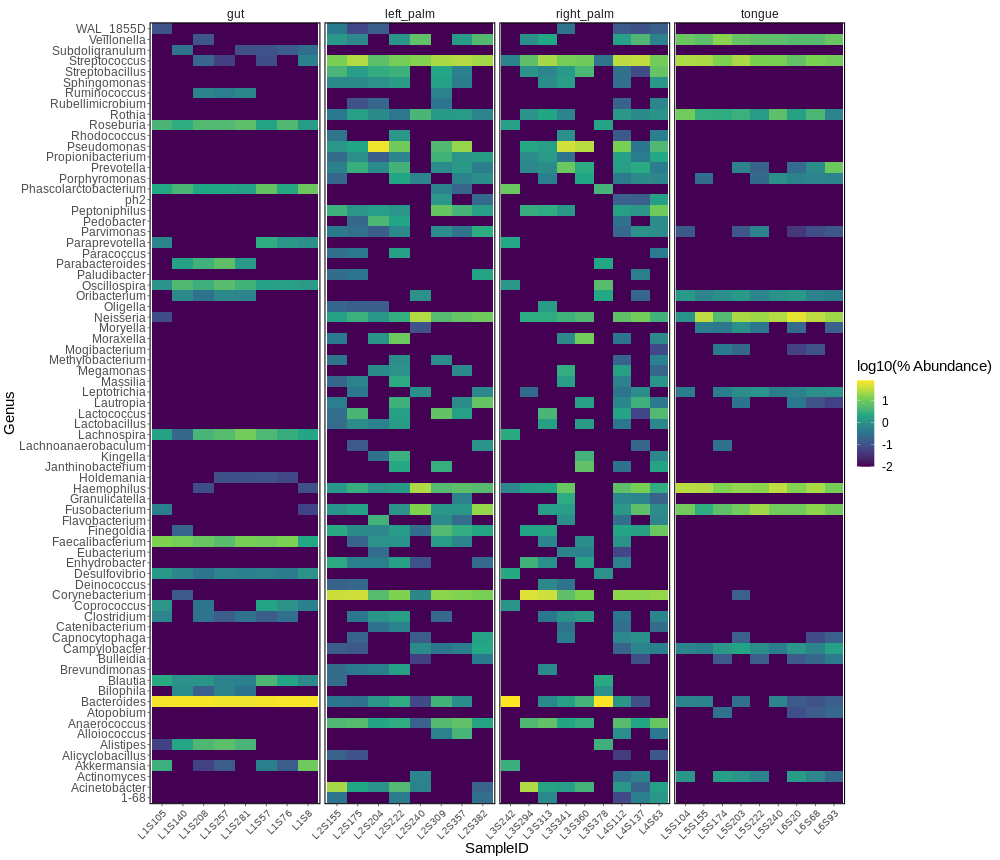

In [ ]:
%%R -w 1000 -h 860 -u px
SVs<-as.data.frame(otu_table(physeq_Genus))
taxonomy<-as.data.frame(tax_table(physeq_Genus))
taxonomy$Feature.ID <- rownames(taxonomy)
taxonomy$Taxon <- paste0(taxonomy$Kingdom, "_", taxonomy$Phylum, "_", taxonomy$Class, "_", taxonomy$Order, "_", taxonomy$Family, "_", taxonomy$Genus)
metadata$SampleID <- as.character(metadata$SampleID)

SVs<-apply(SVs, 2, function(x) x/sum(x)*100) #convert to percent

SV1 <- SVs %>%
  as.data.frame() %>%
  rownames_to_column("Feature.ID") %>%
  gather(-Feature.ID, key="SampleID", value="Abundance") %>%
  group_by(SampleID, Feature.ID) %>%
  summarize(Abundance=sum(Abundance)) %>%
  left_join(metadata) %>%
  mutate(NormAbundance=log10(Abundance+0.01)) %>% # do a log10 transformation after adding a 0.01% pseudocount. Could also add 1 read before transformation to percent
  left_join(taxonomy)

SV1$Genus = str_remove_all(SV1$Genus,"[\\[\\]]")

p1 <- ggplot(SV1, aes(x=SampleID, y=Genus, fill=NormAbundance)) +
  geom_tile() +
  facet_grid(paste0('~', SV1[,grouping]), scales="free_x") +
  theme_q2r() +
  theme(axis.text.x=element_text(angle=45, hjust=1, size=10), text = element_text(size = 15)) +
  scale_y_discrete(labels = function(x) stringr::str_wrap(x, width = 65)) +
  scale_fill_viridis_c(name="log10(% Abundance)")

p1

**QUESTION**

How many features are observed across all 34 samples before filtering?"

A) "1,278"

B) "9,820"

C) "770"

D) "153,807"

### Bar plot.

</br>
Lets look at the proportion of the different genra per sample. For the first plot I use the phyloseq object in which ASVs are not agglomerated at a genus level and therefore the ASVs with unassigned genus are not removed. For the second plot I use the phyloseq object in which ASVs have been agglomerated at genus level and thus the features with unassigned genus are removed.


</br>


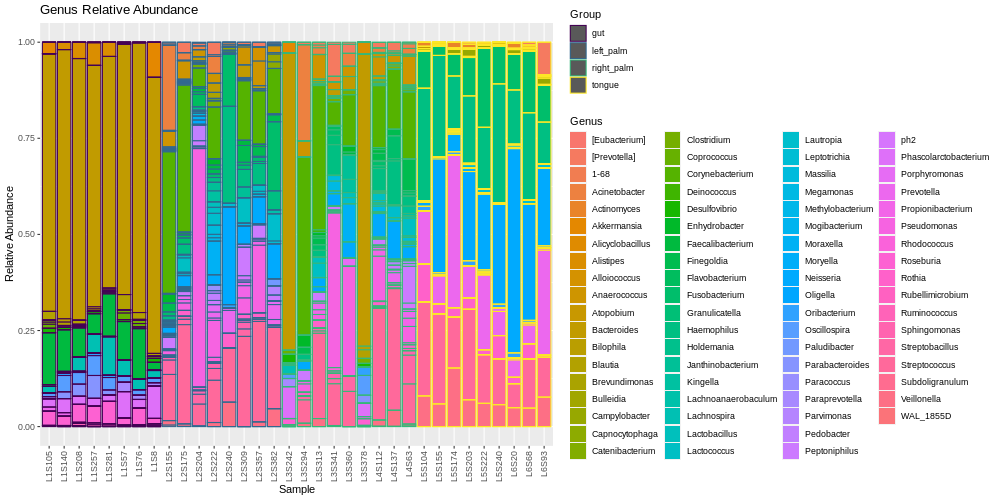

In [ ]:
%%R -w 1000 -h 500 -u px
library(viridis)
p2 = psmelt(physeq_Genus2) %>%
    ggplot(aes(x = Sample, y = Abundance, fill = Genus, color = Group)) +
    geom_bar(position = "stack", stat = "identity") +
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5)) +
    labs(y = "Relative Abundance", title = "Genus Relative Abundance") + scale_color_viridis(discrete=TRUE)
p2

### Phylogenetic tree.     

</br>
It would also be useful to look at how the different lineages in the sample are related. This is a phylogenetic tree of the features present in the sample. The nodes are coloured by the genus and a ring around has plotted abundance in boxplots across all samples (minimum abundance  - 50). The boxplots are coloured by phylum.


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
The `new_scale_color()` was used in the internal.
The aesthetics : colour_new was renamed to colour_new_new,
please specify the `aesthetics="colour_new_new"` in the `scale_color_manual()`
or `scale_color_continuous()` etc. to adjust the `colour`.


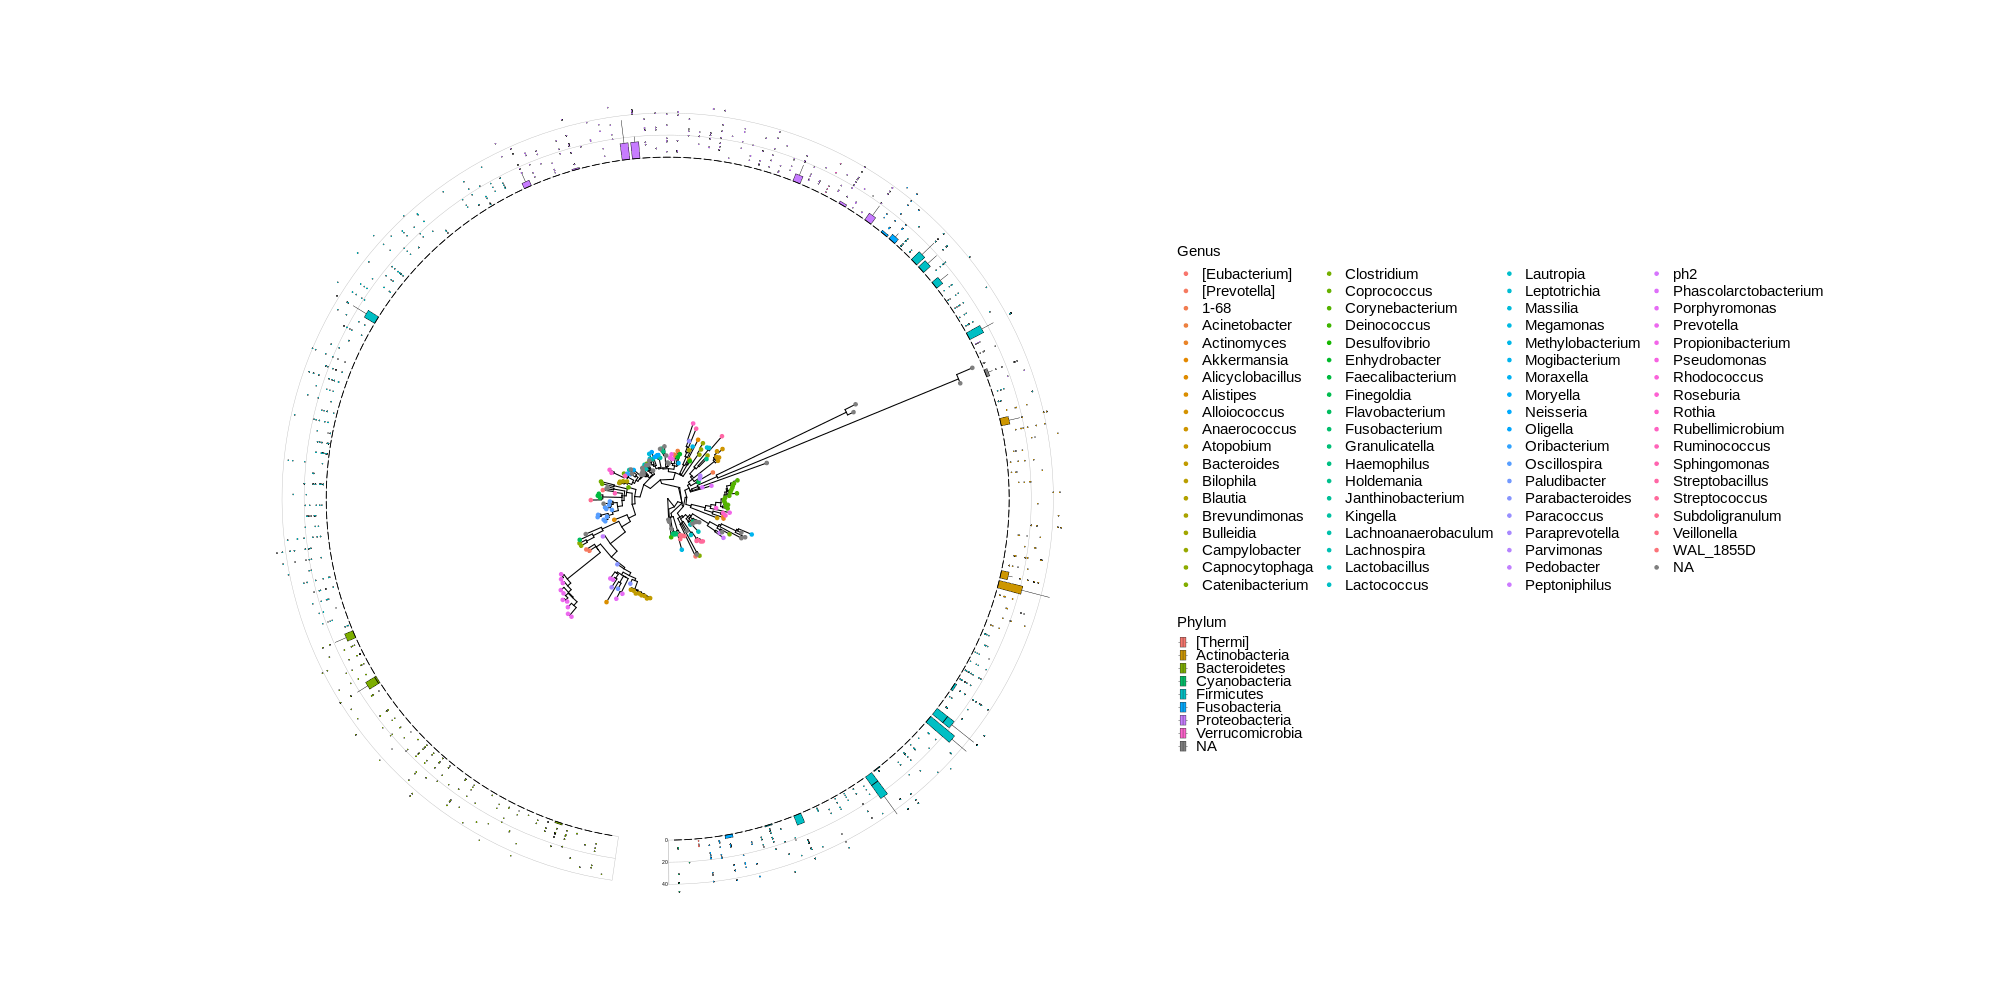

In [ ]:
%%R -w 2000 -h 1000 -u px
melt_simple <- psmelt(physeq1) %>%
               filter(Abundance < 50) %>%
               dplyr::select(OTU, val=Abundance)

p <- ggtree(physeq1, layout="fan", open.angle=10) +
     geom_tippoint(mapping=aes(color=Genus),
                   size=1.5,
                   show.legend=TRUE)
p <- rotate_tree(p, -90)
p <- p + geom_fruit(data=melt_simple, geom=geom_boxplot,
         mapping = aes(
                     y=OTU,
                     x=val,
                     group=label,
                     fill=Phylum),
         size=.2,
         outlier.size=0.5,
         outlier.stroke=0.08,
         outlier.shape=21,
         axis.params=list(
                         axis       = "x",
                         text.size  = 1.8,
                         hjust      = 1,
                         vjust      = 0.5,
                         nbreak     = 3),
         grid.params=list())
p <- p + scale_fill_discrete( name="Phylum", guide=guide_legend(keywidth=0.8, keyheight=0.8, ncol=1)) +
     theme(legend.title=element_text(size=15), legend.text=element_text(size=15))
p

### Venn Diagram.   
</br>
How are the ASVs/Genra/Phyla distributed across the groups?
</br>

Joining with `by = join_by(SampleID)`
Joining with `by = join_by(Feature.ID)`


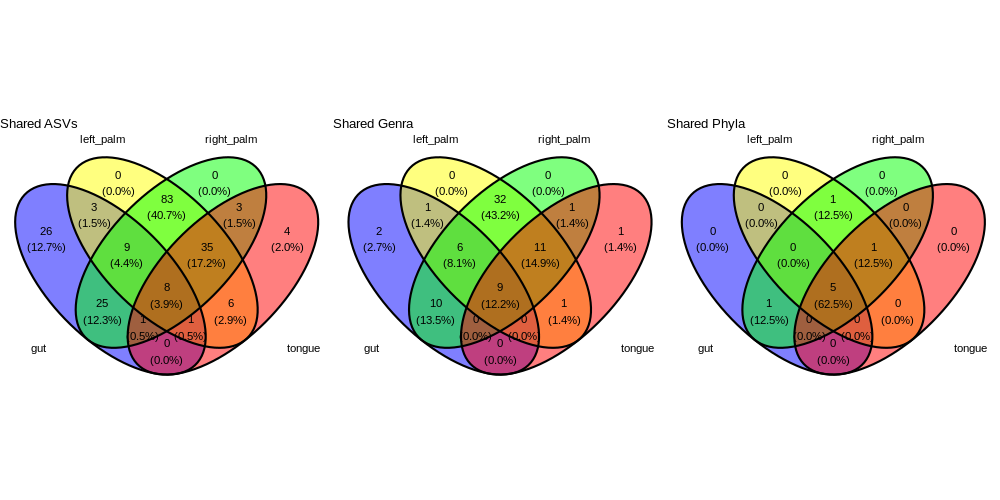

In [ ]:
%%R -w 1000 -h 500 -u px
SVs<-as.data.frame(otu_table(physeq1))
taxonomy<-as.data.frame(tax_table(physeq1))
taxonomy$Feature.ID <- rownames(taxonomy)
metadata$SampleID <- as.character(metadata$SampleID)

SV1 <- SVs %>%
  as.data.frame() %>%
  rownames_to_column("Feature.ID") %>%
  gather(-Feature.ID, key="SampleID", value="Abundance") %>%
  group_by(SampleID, Feature.ID) %>%
  left_join(metadata) %>%
  left_join(taxonomy)

x1 <- list()
for (group in levels(as.factor(metadata[,grouping]))) {
  x1[[group]] <- unique(SV1$Feature.ID[SV1$Abundance >= 1 & SV1[,grouping] == group])
}

x2 <- list()
for (group in levels(as.factor(metadata[,grouping]))) {
  x2[[group]] <- unique(SV1$Genus[SV1$Abundance >= 1 & SV1[,grouping] == group])
}

x3 <- list()
for (group in levels(as.factor(metadata[,grouping]))) {
  x3[[group]] <- unique(SV1$Phylum[SV1$Abundance >= 1 & SV1[,grouping] == group])
}

if (length(levels(as.factor(metadata$Group))) <= 5) {
  venn1 <- ggvenn(
    x1,
    set_name_size = 4, text_size = 4) + ggtitle("Shared ASVs")
  venn2 <- ggvenn(
    x2,
    set_name_size = 4, text_size = 4
  ) + ggtitle("Shared Genra")
  venn3 <- ggvenn(
    x3,
    set_name_size = 4, text_size = 4
  ) + ggtitle("Shared Phyla")
}

x1 <- rapply(x1, na.omit, how = "replace")
x2 <- rapply(x2, na.omit, how = "replace")
x3 <- rapply(x3, na.omit, how = "replace")

m1 = make_comb_mat(x1, mode = "distinct")
m2 = make_comb_mat(x2, mode = "distinct")
m3 = make_comb_mat(x3, mode = "distinct")

if (length(levels(as.factor(metadata$Group))) > 5) {
  venn1 <- UpSet(
    m = m1,
    comb_order = order(comb_size(m1), decreasing = T),
    top_annotation = upset_top_annotation(m1, add_numbers = TRUE),
    right_annotation = upset_right_annotation(m1, add_numbers = TRUE)
  )
  venn2 <- UpSet(
    m = m2,
    comb_order = order(comb_size(m1), decreasing = T),
    top_annotation = upset_top_annotation(m1, add_numbers = TRUE),
    right_annotation = upset_right_annotation(m1, add_numbers = TRUE)
  )
  venn3 <- UpSet(
    m = m3,
    comb_order = order(comb_size(m1), decreasing = T),
    top_annotation = upset_top_annotation(m1, add_numbers = TRUE),
    right_annotation = upset_right_annotation(m1, add_numbers = TRUE)
  )
}

plotGrob <- plot_grid(venn1, venn2, venn3, nrow=1, ncol=3, byrow=FALSE)
print(plot_grid(plotGrob, nrow=1, ncol=1, rel_heights=c(1, 15)))

## Alpha diversity

### Rarefaction curve

We rarified the data before calculating alpha and beta diversity. Lets see if the threshold we applied was reasonable and what we could expect from the data if we rarefied at different depth:



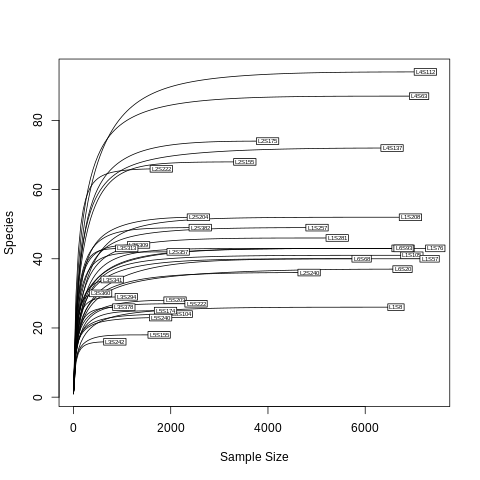

In [ ]:
%%R
otu_tab <- t(abundances(physeq1))
p <- rarecurve(otu_tab, step=50, cex=0.5)

### All measures

Joining with `by = join_by(SampleID)`
Joining with `by = join_by(SampleID)`
Joining with `by = join_by(SampleID)`


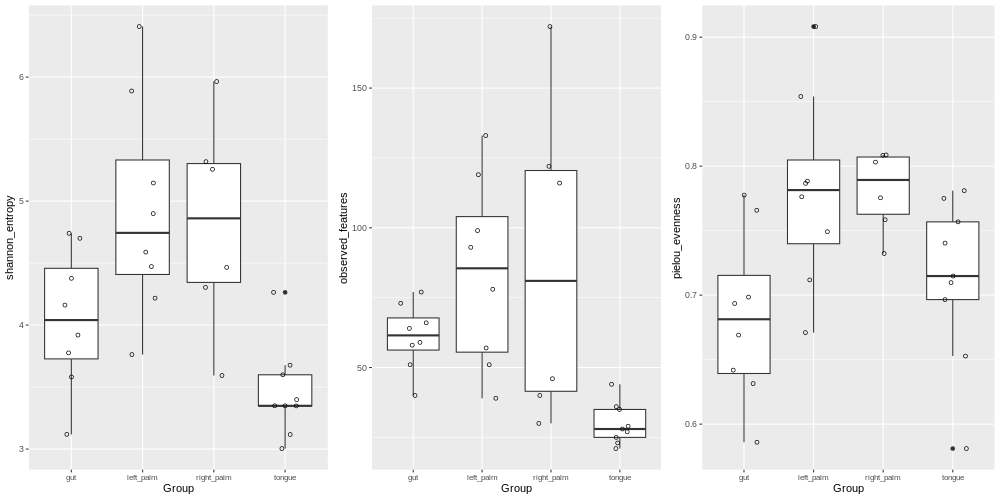

In [ ]:
%%R -w 1000 -h 500 -u px
metadata <- metadata %>% left_join(shannon) %>% left_join(richness) %>% left_join(evenness)

fig <- ggplot(metadata, aes(x=metadata[,grouping], y=shannon_entropy)) +
  geom_boxplot() +
  geom_jitter(shape=21, width=0.2, height=0) +
  xlab(grouping)  + theme(axis.text.x = element_text(size= 8))


fig2 <- ggplot(metadata, aes(x=metadata[,grouping], y=observed_features)) +
  geom_boxplot() +
  geom_jitter(shape=21, width=0.2, height=0) +
  xlab(grouping)  + theme(axis.text.x = element_text(size= 8))


fig3 <- ggplot(metadata, aes(x=metadata[,grouping], y=pielou_evenness)) +
  geom_boxplot() +
  geom_jitter(shape=21, width=0.2, height=0) +
  xlab(grouping)  + theme(axis.text.x = element_text(size= 8))

plot_grid(fig, fig2, fig3, ncol = 3)


### Plots with marked significance - mean comparisons

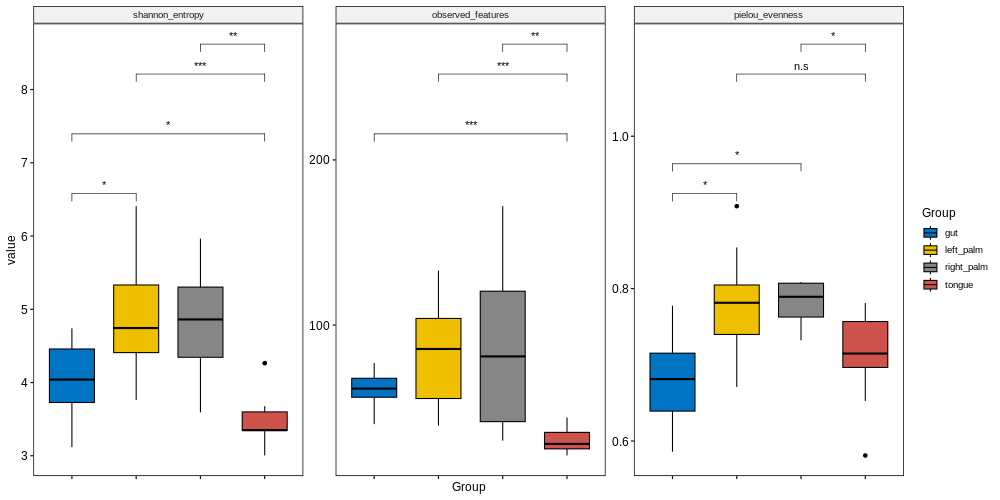

In [ ]:
%%R -w 1000 -h 500 -u px
metadata_melt <- reshape2::melt(metadata)
lev <- levels(as.factor(metadata_melt$Group)) # get the variables

# make a pairwise list that we want to compare.
L.pairs <- combn(seq_along(lev), 2, simplify = FALSE, FUN = function(i) lev[i])

pval <- list(
  cutpoints = c(0, 0.0001, 0.001, 0.01, 0.05, 0.1, 1),
  symbols = c("****", "***", "**", "*", "n.s")
)

p <- ggboxplot(metadata_melt, x = grouping, y = "value",
              fill = grouping,
              palette = "jco",
              legend= "right",
              facet.by = "variable",
              scales = "free") + rremove("x.text")
p2 <- p + stat_compare_means(
  comparisons = L.pairs,
  label = "p.signif",
  symnum.args = list(
    cutpoints = c(0, 0.0001, 0.001, 0.01, 0.05, 0.1, 1),
    symbols = c("****", "***", "**", "*", "n.s")
  )
)

print(p2)

### Shannon diversity significance - Kruskal-Wallis

</br>

#### Kruskal-Wallis all groups


In [ ]:
%%R
m <- kruskal.test(metadata$shannon_entropy ~ metadata$Group)
knitr::knit_print(paste("Global Kruskal-Wallis Chi-squared value = ", m$statistic[[1]]))
knitr::knit_print(paste("Global Kruskal-Wallis p-value = ", round(m$p.value,4)))


[1] "Global Kruskal-Wallis Chi-squared value =  15.9632056451613"
[1] "Global Kruskal-Wallis p-value =  0.0012"


#### Kruskal-Wallis (pairwise)

In [ ]:
%%R
if (length(levels(as.factor(metadata$Group))) > 2){
  print(wilcox_test(data = metadata, formula = as.formula(paste("shannon_entropy", "~", "Group")), p.adjust.method = "BH")[,c("group1", "group2", "n1", "n2", "statistic", "p", "p.adj", "p.adj.signif")])
} else {
  print(pairwise_wilcox_test(data = metadata, formula = as.formula(paste("shannon_entropy", "~", "Group")), p.adjust.method = "BH")[,c("group1", "group2", "n1", "n2", "statistic", "p", "p.adj", "p.adj.signif")])
}

# A tibble: 6 × 8
  group1     group2        n1    n2 statistic        p p.adj p.adj.signif
  <chr>      <chr>      <int> <int>     <dbl>    <dbl> <dbl> <chr>       
1 gut        left_palm      8     8        13 0.05     0.075 ns          
2 gut        right_palm     8     6        11 0.108    0.13  ns          
3 gut        tongue         8     9        59 0.027    0.055 ns          
4 left_palm  right_palm     8     6        25 0.95     0.95  ns          
5 left_palm  tongue         8     9        70 0.000329 0.002 **          
6 right_palm tongue         6     9        51 0.003    0.008 **          


## Beta diversity

### Jaccard Diversity Index.
#### Bar plot


Joining with `by = join_by(SampleID)`
Joining with `by = join_by(SampleID)`


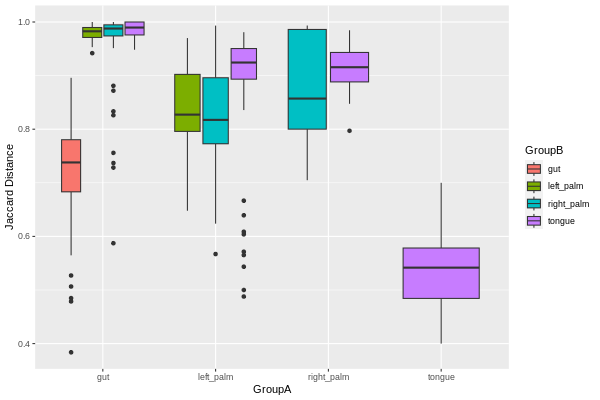

In [ ]:
%%R -w 600 -h 400 -u px
xy <- t(combn(colnames(jaccardmatrix),2))
jaccard_distance <- data.frame(xy, dist=jaccardmatrix[xy])
colnames(jaccard_distance) <- c("Sample1", "Sample2", "dist")
jaccard_distance <- jaccard_distance %>% mutate(SampleID = Sample1) %>% left_join(metadata) %>% mutate(GroupA = Group) %>% select(c(Sample1,Sample2,dist, GroupA)) %>% mutate(SampleID=Sample2)  %>% left_join(metadata) %>% mutate(GroupB = Group) %>% select(c(Sample1,Sample2,dist, GroupA, GroupB))

p1 <- ggplot(jaccard_distance, aes(x=GroupA, y=dist, fill = GroupB)) + geom_boxplot() + xlab("GroupA") + ylab("Jaccard Distance")

p1

#### PCoA

Joining with `by = join_by(SampleID)`
Joining with `by = join_by(SampleID, shannon_entropy)`


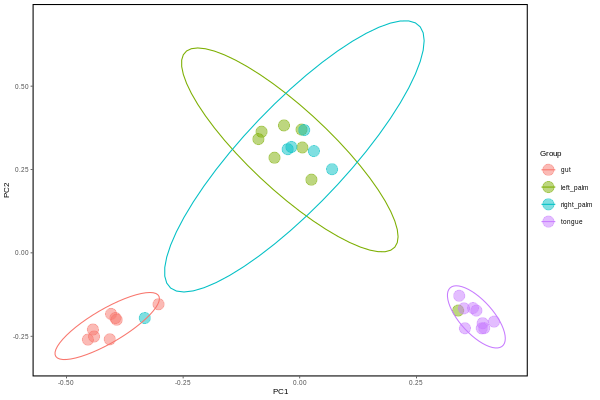

In [ ]:
%%R -w 600 -h 400 -u px
jaccard2 <- jaccard$data$Vectors %>% select(SampleID, PC1, PC2) %>% left_join(metadata) %>% left_join(shannon)

#jaccard$data$Vectors %>%
#  select(SampleID, PC1, PC2) %>%
#  left_join(metadata) %>%
#  left_join(shannon) %>%
#  ggplot(aes(x=PC1, y=PC2, color=`Group`, shape=`Housing`, size=shannon)) +
#  geom_point(alpha=0.5) + #alpha controls transparency and helps when points are overlapping
#  theme_q2r() +
#   scale_shape_manual(values=c(16,1), name="Housing") + #see http://www.sthda.com/sthda/RDoc/figure/graphs/r-plot-pch-symbols-points-in-r.png for numeric shape codes
#  scale_size_continuous(name="Shannon Diversity") +
#  scale_color_discrete(name="Group")

ggplot(jaccard2, aes(x=PC1, y=PC2, color=jaccard2[,grouping])) +
  geom_point(alpha=0.5, size = 5) +
  theme_q2r() +
  scale_color_discrete(name=grouping) + stat_ellipse()

#### Permanova results

In [ ]:
%%R -w 1000
metadata2 <- metadata[metadata$SampleID %in% rownames(jaccardmatrix),]
permanova <- adonis2(jaccardmatrix ~ metadata2$Group, permutations = 999, method = "jaccard")
knitr::knit_print(paste0("Global PERMANOVA p-value = ", permanova$`Pr(>F)`[1]))
knitr::knit_print(paste0("Global PERMANOVA F-statistic = ", round(permanova$F[1],2)))
print(pairwise.adonis(jaccardmatrix, metadata2$Group, perm = 999, sim.method = "jaccard")[,c("pairs", "SumsOfSqs", "F.Model", "R2", "p.value", "p.adjusted")] %>% select(c("pairs", "SumsOfSqs", "F.Model", "R2", "p.value", "p.adjusted")))


[1] "Global PERMANOVA p-value = 0.001"
[1] "Global PERMANOVA F-statistic = 5.48"
                    pairs   SumsOfSqs    F.Model         R2 p.value p.adjusted
1        gut vs left_palm 0.159738289 22.0917842 0.61210009   0.001      0.006
2       gut vs right_palm 0.112821303 15.6832599 0.56652504   0.002      0.012
3           gut vs tongue 0.334319977 89.4012284 0.85632353   0.001      0.006
4 left_palm vs right_palm 0.005139321  0.4930083 0.03946274   0.995      1.000
5     left_palm vs tongue 0.154385420 24.4123117 0.61940827   0.001      0.006
6    right_palm vs tongue 0.153200715 24.9085725 0.65706965   0.001      0.006


### Bray Curtis Dissimilarity.

#### Barplot

Joining with `by = join_by(SampleID)`
Joining with `by = join_by(SampleID)`


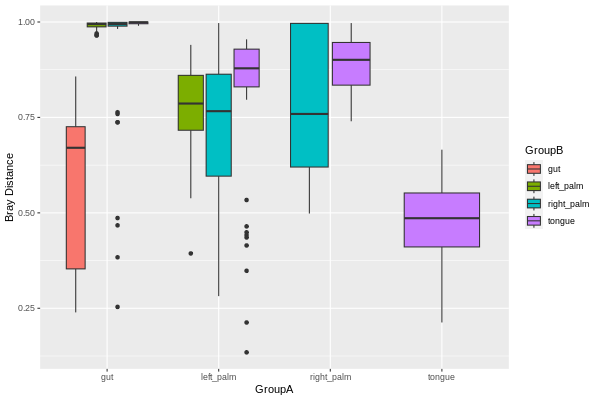

In [ ]:
%%R -w 600 -h 400 -u px
bc <- t(combn(colnames(braymatrix),2))
bray_distance <- data.frame(bc, dist=braymatrix[bc])
colnames(bray_distance) <- c("Sample1", "Sample2", "dist")
bray_distance <- bray_distance %>% mutate(SampleID = Sample1) %>% left_join(metadata) %>% mutate(GroupA = Group) %>% select(c(Sample1,Sample2,dist, GroupA)) %>% mutate(SampleID=Sample2)  %>% left_join(metadata) %>% mutate(GroupB = Group) %>% select(c(Sample1,Sample2,dist, GroupA, GroupB))

p1 <- ggplot(bray_distance, aes(x=GroupA, y=dist, fill = GroupB)) + geom_boxplot() + xlab("GroupA") + ylab("Bray Distance")

p1

#### PCoA

Joining with `by = join_by(SampleID)`
Joining with `by = join_by(SampleID)`


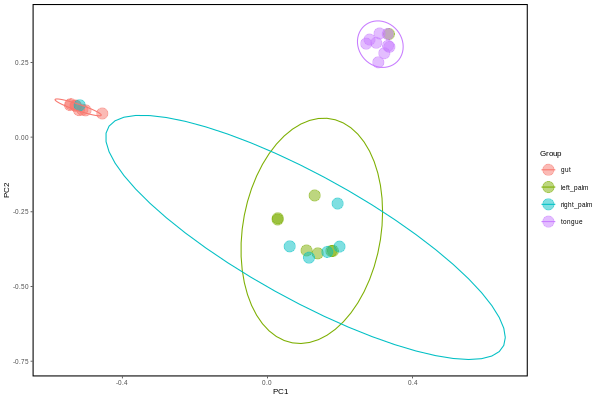

In [ ]:
%%R -w 600 -h 400 -u px
bray2 <- bray$data$Vectors %>% select(SampleID, PC1, PC2) %>% left_join(metadata) %>% left_join(shannon)

ggplot(bray2, aes(x=PC1, y=PC2, color=bray2[,grouping])) +
  geom_point(alpha=0.5, size = 5) +
  theme_q2r() +
  scale_color_discrete(name=grouping) + stat_ellipse()

#### Permanova results

In [ ]:
%%R
permanova <- adonis2(braymatrix ~ metadata2$Group, permutations = 999, method = "bray")
knitr::knit_print(paste0("Global PERMANOVA p-value = ", permanova$`Pr(>F)`[1]))
knitr::knit_print(paste0("Global PERMANOVA F-statistic = ", round(permanova$F[1],2)))
print(pairwise.adonis(braymatrix, metadata2$Group, perm = 999, sim.method = "bray")[,c("pairs", "SumsOfSqs", "F.Model", "R2", "p.value", "p.adjusted")] %>% select(c("pairs", "SumsOfSqs", "F.Model", "R2", "p.value", "p.adjusted")))


[1] "Global PERMANOVA p-value = 0.001"
[1] "Global PERMANOVA F-statistic = 7.94"
                    pairs   SumsOfSqs     F.Model         R2 p.value p.adjusted
1        gut vs left_palm 0.131705474  33.6425749 0.70614519   0.001      0.006
2       gut vs right_palm 0.090486138  19.1731144 0.61505290   0.001      0.006
3           gut vs tongue 0.216285248 132.1279232 0.89804791   0.001      0.006
4 left_palm vs right_palm 0.003921763   0.5604572 0.04462077   0.821      1.000
5     left_palm vs tongue 0.069031705  19.9551432 0.57087860   0.001      0.006
6    right_palm vs tongue 0.082119466  19.8742214 0.60455337   0.001      0.006


### Weighted UniFrac distance.

#### Bar plot

Joining with `by = join_by(SampleID)`
Joining with `by = join_by(SampleID)`


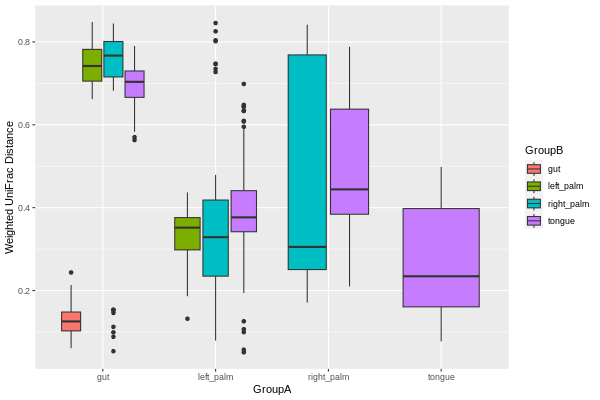

In [ ]:
%%R -w 600 -h 400 -u px
bc <- t(combn(colnames(unifracmatrix),2))
unifrac_distance <- data.frame(bc, dist=unifracmatrix[bc])
colnames(unifrac_distance) <- c("Sample1", "Sample2", "dist")
unifrac_distance <- unifrac_distance %>% mutate(SampleID = Sample1) %>% left_join(metadata) %>% mutate(GroupA = Group) %>% select(c(Sample1,Sample2,dist, GroupA)) %>% mutate(SampleID=Sample2)  %>% left_join(metadata) %>% mutate(GroupB = Group) %>% select(c(Sample1,Sample2,dist, GroupA, GroupB))

p1 <- ggplot(unifrac_distance, aes(x=GroupA, y=dist, fill = GroupB)) + geom_boxplot() + xlab("GroupA") + ylab("Weighted UniFrac Distance")

p1

#### PCoA


Joining with `by = join_by(SampleID)`
Joining with `by = join_by(SampleID)`


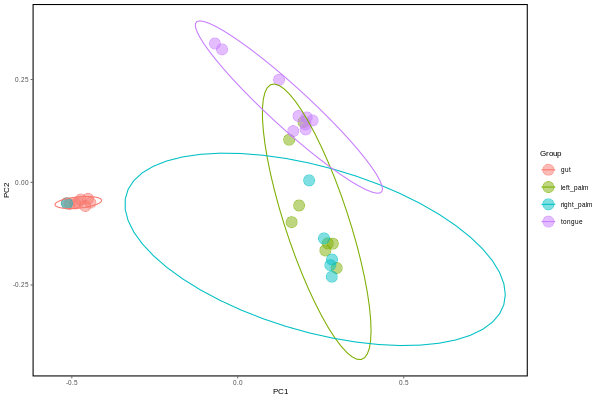

In [ ]:
%%R -w 600 -h 400 -u px
unifrac <- unifrac$data$Vectors %>% select(SampleID, PC1, PC2) %>% left_join(metadata) %>% left_join(shannon)

ggplot(unifrac, aes(x=PC1, y=PC2, color=unifrac[,grouping])) +
  geom_point(alpha=0.5, size = 5) +
  theme_q2r() +
  scale_color_discrete(name=grouping) + stat_ellipse()

#### Permanova results

In [ ]:
%%R
permanova <- adonis2(unifracmatrix ~ metadata2$Group, permutations = 999, method = "uni")
knitr::knit_print(paste0("Global PERMANOVA p-value = ", permanova$`Pr(>F)`[1]))
knitr::knit_print(paste0("Global PERMANOVA F-statistic = ", round(permanova$F[1],2)))
print(pairwise.adonis(unifracmatrix, metadata2$Group, perm = 999, sim.method = "bray")[,c("pairs", "SumsOfSqs", "F.Model", "R2", "p.value", "p.adjusted")] %>% select(c("pairs", "SumsOfSqs", "F.Model", "R2", "p.value", "p.adjusted")))


[1] "Global PERMANOVA p-value = 0.001"
[1] "Global PERMANOVA F-statistic = 18.72"
                    pairs  SumsOfSqs    F.Model         R2 p.value p.adjusted
1        gut vs left_palm 0.85581247 201.700240 0.93509511   0.001      0.006
2       gut vs right_palm 0.52523029  28.467449 0.70346537   0.002      0.012
3           gut vs tongue 0.85087051 141.400768 0.90409254   0.001      0.006
4 left_palm vs right_palm 0.02484980   1.097023 0.08376127   0.377      1.000
5     left_palm vs tongue 0.05839803   6.226538 0.29333742   0.005      0.030
6    right_palm vs tongue 0.08805927   3.782065 0.22536351   0.018      0.108


#### Homogeneity of variance

In [ ]:
%%R
dispersion <- betadisper(as.dist(unifracmatrix), metadata2$Group)
permutest(dispersion, pairwise = TRUE)


Permutation test for homogeneity of multivariate dispersions
Permutation: free
Number of permutations: 999

Response: Distances
          Df  Sum Sq  Mean Sq      F N.Perm Pr(>F)  
Groups     3 0.12673 0.042244 2.4638    999  0.061 .
Residuals 27 0.46293 0.017145                       
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Pairwise comparisons:
(Observed p-value below diagonal, permuted p-value above diagonal)
                  gut  left_palm right_palm tongue
gut                   1.0000e-03 4.1000e-02  0.029
left_palm  8.6394e-05            6.9400e-01  0.405
right_palm 6.6068e-02 6.2250e-01             0.372
tongue     6.3768e-02 3.4969e-01 3.5789e-01       


**QUESTION**

Do body parts differ in species composition (jaccard diversity) and/or species abundance (bray curtis diversity)?",

A) "More samples are needed to answer this question"

B) "There is no significant difference between the different body parts"

C) "The different body parts differ in species diversity except for right and left palm"

D) "The different body parts differ in species abundance only"

## Differential abundance tests

### Properties of taxonomic profiling data

#### Overdispersion
</br>
Let's check if the variance exceeds the mean over all samples for each taxon.


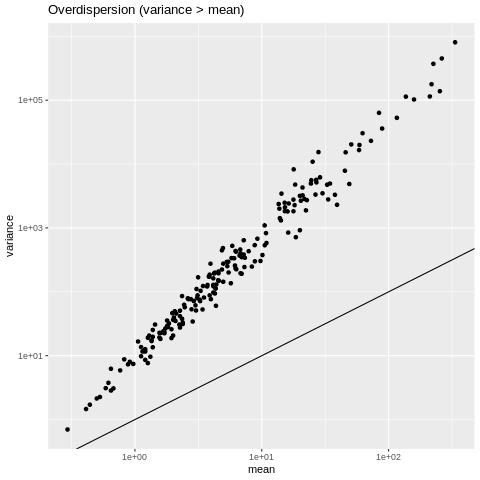

In [ ]:
%%R
library(data.table)
means <- apply(otu_table(physeq1),1,mean)
variances <- apply(otu_table(physeq1),1,var)
df <- melt(otu_table(physeq1))
names(df) <- c("Taxon", "Sample", "Reads")
df <- df %>% group_by(Taxon) %>%
             summarise(mean = mean(Reads),
                   variance = var(Reads))

# Illustrate overdispersion
library(scales)
p <- ggplot(df, aes(x = mean, y = variance)) +
       geom_point() +
       geom_abline(aes(intercept = 0, slope = 1)) +
       scale_x_log10(labels = scales::scientific) +
       scale_y_log10(labels = scales::scientific) +
       labs(title = "Overdispersion (variance > mean)")
p

#### Sparsity.  
</br>
Is the data sparsely distributed?


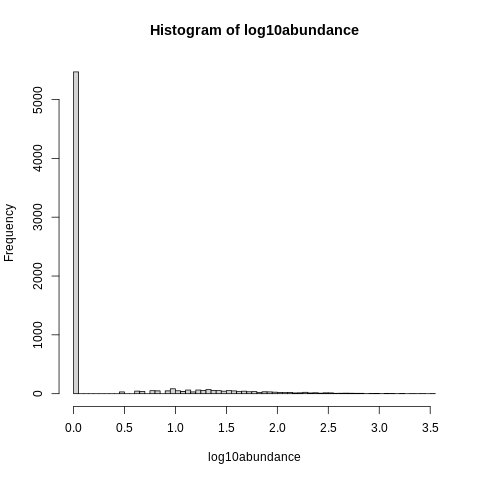

In [ ]:
%%R
log10abundance <- reshape2::melt(log10(1 + otu_table(physeq1)))$value
hist(log10abundance, 100)

#### Rarity.      
</br>
Do we see a lot of rare taxa?


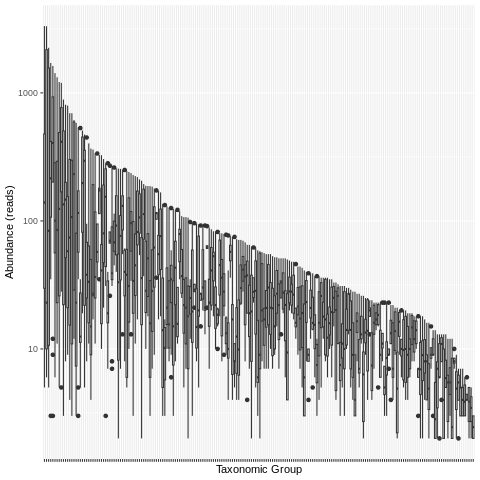

In [ ]:
%%R
medians <- apply(otu_table(physeq1),1,median)/1e3
A <- reshape2::melt(otu_table(physeq1))
A = A %>% arrange(desc(value))
A$Var1 = factor(A$Var1, levels = unique(A$Var1))
p <- ggplot(A, aes(x = Var1, y = value)) +
        geom_boxplot() + theme(axis.text.x = element_blank()) +
    labs(y = "Abundance (reads)", x = "Taxonomic Group") +
    scale_y_log10()

print(p)

#### Rareify or not to rareify

We do not rareify the data as there have been arguments in the literature against doing so.
Rarefiying:     
+ requires an arbitrary selection of a library size minimum threshold,    
+ implies getting rid of informative data and       
+ has been shown to cause adds artificial uncertainty      
+ as well as an increase in Type-I and Type-II error.     

If you would like to know more, read the following publication:
</br>
+[Waste Not, Want Not: Why Rarefying Microbiome Data Is Inadmissible](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1003531)

#### Differential abundance testing.      
</br>
Advanced methods of differential abundance testing based on linear regression are applied because sequencing data sets deviate from symmetric, continuous, Gaussian assumptions in many ways. Types of tests that were applied:

- ANCOMBC (Analysis of Microbial Composition with Bias Correction).   
- LEFse (LDA Effect Size).   
- DESeq2.   
- EdgeR.
- Combination of EdgeR and DESeq2.  



</br>

### ANCOM-BC

ANCOM is claimed to produce the most consistent results and is probably a conservative approach. See +[here](https://www.nature.com/articles/s41467-022-28034-z) for more information. The method incorporates sampling fraction into the model which is estimated as the ratio of the library size to the microbial load. It also controls for the false discovery rate. For the analysis we will agglomerate features by Genus, we will eliminate any taxa that appear in below 10% of samples and we will correct the p-value with Bonferroni Hochberg correction method.  We will consider as significant only the taxa for which the q-value is below 0.05.


In [ ]:
%%R
res<- ANCOMBC::ancombc(phyloseq = physeq,
                 formula = grouping,
                 tax_level = "Genus",
                 p_adj_method = "BH",
                 lib_cut = 0,
                 prv_cut = 0.1,
                 group = grouping,
                 struc_zero = TRUE,
                 neg_lb = TRUE,
                 tol = 1e-5,
                 max_iter = 100,
                 conserve = TRUE,
                 alpha = 0.05,
                 global = TRUE)


Error in loadNamespace(x) : there is no package called ‘ANCOMBC’


#### ANCOM-BC Primary Test Results

Result from the ANCOM-BC log-linear model to determine taxa that are differentially abundant according to the covariate of interest. It contains: 1) log fold changes; 2) standard errors; 3) test statistics; 4) p-values; 5) adjusted p-values; 6) indicators whether the taxon is differentially abundant (TRUE) or not (FALSE).

</br>
Lets look at table 6).Each group is compared to reference group and if the difference is significant the output is TRUE.


In [ ]:
%%R
print(res$res$diff_abn)

</br>
Lets look at table 1): the Log Fold Changes from the Primary Result.
</br>

In [ ]:
%%R
tab_lfc = res$res$lfc
tab_lfc %>% datatable(caption = "Log Fold Changes from the Primary Result") %>% formatRound(colnames(tab_lfc)[-1], digits = 2)


</br>
Lets look at table 5): the adjusted p-values.
</br>

In [ ]:
%%R
tab_q = res$res$q_val
tab_q %>%
  datatable(caption = "Adjusted p-values from the Primary Result") %>%
  formatRound(colnames(tab_q)[-1], digits = 2)

Lets obtain bias-corrected abundances.    
Step 1: obtain estimated sample-specific sampling fractions (in log scale).     
Step 2: correct the log observed abundances by subtracting the estimated sampling fraction from log observed abundances of each sample.    
</br>
Note that we are only able to estimate sampling fractions up to an additive constant. Thus, only the difference between bias-corrected abundances are meaningful.    
</br>

In [ ]:
%%R
samp_frac = res$samp_frac
# Replace NA with 0
samp_frac[is.na(samp_frac)] = 0
# Add pesudo-count (1) to avoid taking the log of 0
log_obs_abn = log(res$feature_table + 1)
# Adjust the log observed abundances
log_corr_abn = t(t(log_obs_abn) - samp_frac)
# Show the first 6 samples
round(log_corr_abn[, 1:6], 2) %>%
  datatable(caption = "Bias-corrected log observed abundances")

</br>
Lets visualise log fold changes per grouping factor.
</br>

In [ ]:
%%R
tab_lfc = data.frame(res$res$lfc[, -1] * res$res$diff_abn[, -1], check.names = FALSE) %>%
  mutate(taxon_id = res$res$diff_abn$taxon) %>%
  dplyr::select(taxon_id, everything())
tab_se = data.frame(res$res$se[, -1] * res$res$diff_abn[, -1], check.names = FALSE) %>%
  mutate(taxon_id = res$res$diff_abn$taxon) %>%
  dplyr::select(taxon_id, everything())
colnames(tab_se)[-1] = paste0(colnames(tab_se)[-1], "SE")

for (i in colnames(tab_lfc)[grepl("Group",colnames(tab_lfc))]) {
  x = colnames(tab_se)[grepl("Group",colnames(tab_se)) & grepl("SE",colnames(tab_se))]
  tab_for_plot = tab_lfc %>%
  dplyr::left_join(tab_se, by = "taxon_id") %>%
  dplyr::transmute(tab_lfc$taxon_id, tab_lfc[,i], tab_se[,x]) %>%
    dplyr::rename("taxon_id" = 1, "fold_change" = 2, "SE" = 3) %>%
    dplyr::filter(fold_change != 0) %>%
    dplyr::arrange(desc(fold_change)) %>%
    dplyr::mutate(direct = ifelse(fold_change > 0, "Positive LFC", "Negative LFC"))
  tab_for_plot$taxon_id = factor(tab_for_plot$taxon_id, levels = tab_for_plot$taxon_id)
  tab_for_plot$direct = factor(tab_for_plot$direct,
                        levels = c("Positive LFC", "Negative LFC"))

  print(ggplot(data = tab_for_plot,
         aes(x = taxon_id, y = fold_change, fill = direct, color = direct)) +
    geom_bar(stat = "identity", width = 0.7,
           position = position_dodge(width = 0.4)) +
    geom_errorbar(aes(ymin = fold_change - SE, ymax = fold_change - SE), width = 0.2,
                position = position_dodge(0.05), color = "black") +
    labs(x = NULL, y = "Log fold change",
       title = paste("Log fold changes as one unit increase of", i)) +
    scale_fill_discrete(name = NULL) +
    scale_color_discrete(name = NULL) +
    theme_bw() +
    theme(plot.title = element_text(hjust = 0.5),
        panel.grid.minor.y = element_blank(),
        axis.text.x = element_text(size = 6, angle = 60, hjust = 1)))

}

#### ANCOM-BC Global Test Results

If you have more than 2 groups this will also be relevant to you. Result from the ANCOM-BC global test to determine taxa that are differentially abundant between at least two groups across three or more different groups. The result contains: 1) test statistics; 2) p-values; 3) adjusted p-values; 4) indicators whether the taxon is differentially abundant (TRUE) or not (FALSE).

</br>
Lets look at table 1): the Test Statistic


In [ ]:
%%R
if (length(levels(as.factor(metadata$Group))) > 2){
  tab_w = res$res_global[, c("taxon", "W")]
tab_w %>% datatable(caption = "Test Statistics
                    from the Global Test Result") %>%
      formatRound(c("W"), digits = 2)
} else { print("You only have 2 Groups")}

</br>
Lets look at table 3): the Adjusted P-values.
</br>

In [ ]:
%%R
if (length(levels(as.factor(metadata$Group))) > 2){
  tab_q = res$res_global[, c("taxon", "q_val")]
tab_q %>% datatable(caption = "Adjusted p-values
                    from the Global Test Result") %>%
      formatRound(c("q_val"), digits = 2)
} else { print("You only have 2 Groups")}

</br>
Lets look at table 4): the differentially abundant taxa.
</br>


In [ ]:
%%R
if (length(levels(as.factor(metadata$Group))) > 2){
tab_diff = res$res_global[, c("taxon", "diff_abn")]
tab_diff %>% datatable(caption = "Differentially Abundant Taxa
                       from the Global Test Result")
} else { print("You only have 2 Groups")}

</br>
Let's visualise the log fold changes of sample groups to reference group of globally significant taxa.


In [ ]:
%%R
if (length(levels(as.factor(metadata$Group))) > 2){
sig_taxa = res$res_global %>%
  dplyr::filter(diff_abn == TRUE) %>%
  .$taxon

df_sig = tab_lfc %>%
    dplyr::select(-2) %>% rename_with(~str_remove(., 'Group')) %>%
    filter(taxon_id %in% sig_taxa)

df_sig2 = df_sig %>%
    pivot_longer(cols = -one_of("taxon_id"),
                 names_to = "region", values_to = "value") %>%
    mutate(value = round(value, 2))
df_sig2$taxon_id = factor(df_sig2$taxon_id, levels = sort(sig_taxa))

lo = floor(min(df_sig2$value))
up = ceiling(max(df_sig2$value))
mid = (lo + up)/2
p_sig = df_sig2 %>%
  ggplot(aes(x = region, y = taxon_id, fill = value)) +
  geom_tile(color = "black") +
  scale_fill_gradient2(low = "blue", high = "red", mid = "white",
                       na.value = "white", midpoint = mid, limit = c(lo, up),
                       name = NULL) +
  geom_text(aes(region, taxon_id, label = value), color = "black", size = 4) +
  labs(x = NULL, y = NULL,
       title = "Log fold changes for globally significant taxa") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5))
p_sig
} else { print("You only have 2 Groups")}

**QUESTION**

How many genera were found to differ significantly between the different body parts in analysis of microbial composition (ANCOM)?

A) "3"

B) "9"

C) "80"

D) "103"

### LEFse results.

LDA Effect Size (LEfSe) method for microbiome biomarker discovery uses the Kruskal-Wallis test, Wilcoxon-Rank Sum test, and Linear Discriminant Analysis to find biomarkers of the predefined groups. A p-value of < 0.05 and a score ≥ 2.0 are considered significant in Kruskal–Wallis and pairwise Wilcoxon tests, respectively. Analysis is done doing a comparison for each group vs all. Significant LDA scores are displayed.


In [ ]:
%%R
if (length(levels(as.factor(metadata$Group))) > 2){
  mm_lefse <- run_lefse(
    ps = physeq1,
    kw_cutoff = 0.05,
    wilcoxon_cutoff = 0.05,
    group = grouping,
    multigrp_strat = FALSE, #I am using here each group against all instead of pairwise between groups
    lda_cutoff = 2,
    taxa_rank = "all"
  )} else {
    mm_lefse<- run_lefse(
    ps = physeq1,
    kw_cutoff = 0.05,
    wilcoxon_cutoff = 0.05,
    group = grouping,
    multigrp_strat = TRUE, #I am using here each group against all instead of pairwise between groups
    lda_cutoff = 2,
    taxa_rank = "all"
  )
  }
lefseDF <- as.data.frame(marker_table(mm_lefse))
lefseDF$log10p <- -log10(lefseDF$padj)
lefseDF <- lefseDF[order(lefseDF$enrich_group),]
lefseDF$feature <- factor(lefseDF$feature, levels=unique(lefseDF$feature))
df <- as.data.frame(marker_table(mm_lefse))
i = length(unique(df$enrich_group))
list_of_colours = c(viridis_pal(option = "D")(i))

p1 <- plot_ef_dot(mm_lefse)+ scale_color_manual(values=list_of_colours) + theme(axis.text.x = element_text(size=5, angle=0), axis.text.y = element_text(size=5, angle=0))


print(p1)


Error in run_lefse(ps = physeq1, kw_cutoff = 0.05, wilcoxon_cutoff = 0.05,  : 
  could not find function "run_lefse"


In [ ]:
%%R
library(microbiomeMarker)


Error in library(microbiomeMarker) : 
  there is no package called ‘microbiomeMarker’


In [ ]:
%%R
as.data.frame(marker_table(mm_lefse)) %>% datatable(caption = "Marker Table") %>%
      formatRound(c("ef_lda", "pvalue", "padj"), digits = 2)

### DESeq2/EdgeR results

Differential abundance on microbiome data can also be done using DESeq2 or EdgeR. First we convert the filtered phyloseq object into a deseq2 object. phyloseq_to_deseq2() no longer adds pseudocount to the data and a lot of sparsely sampled OTUs can lead to errors. Therefore we first calculate geometric means, then we estimate size factors and then run DESeq2. The significance test for DESeq2 is Wald, p-values are corrected using Bonferroni correction, significance threshold used is 0.05. For edgeR, "Relative Log Expression” normalization is applied to the data and a GLM model is fit, p-values are corrected using Bonferroni correction, significance threshold used is 0.01. For final results I combine both analyses.

#### DESeq2 by Group.  

P-value and LogFC distribution.


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


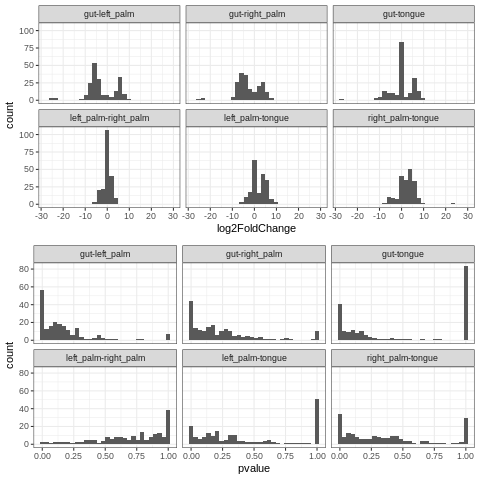

In [ ]:
%%R
Group = get_variable(physeq1, grouping)
ds2 = phyloseq_to_deseq2(physeq1, ~0 + Group)
#phyloseq_to_deseq2() no longer adds pseudocount to the data a lot of sparsely sampled OTUs can lead to errors. I therefore implement this solution: https://github.com/joey711/phyloseq/issues/387
# calculate geometric means prior to estimate size factors
gm_mean = function(x, na.rm=TRUE){
  exp(sum(log(x[x > 0]), na.rm=na.rm) / length(x))
}
geoMeans = apply(counts(ds2), 1, gm_mean)
# estimate size factors
ds2 = estimateSizeFactors(ds2, geoMeans = geoMeans)
#run deseq
ds2 = DESeq(ds2, test="Wald", fitType="local")

contrasts = length(unique(metadata[,grouping]))*(length(unique(metadata[,grouping])) - 1)/2
levels = c(unique(metadata[,grouping]))
comparisons = combn(levels,2, simplify = FALSE)

reses = list()
for (i in comparisons){
  a = as.character(i[1])
  b = as.character(i[2])
  con = c(grouping, a, b)
  res <- as.data.frame(results(ds2, contrast = c(grouping, a, b), cooksCutoff = FALSE))
  res$log10p <- -(log10(res$pvalue))
  res = cbind(as(res, "data.frame"), as(tax_table(physeq1)[rownames(res), ], "matrix"))
  res$contrast = paste0(a,"-", b)
  reses = rbind(reses,res)
}
reses <- reses[!duplicated(reses),]
sigtab = reses[which(reses$padj < 0.01), ]

#Plot a scatterplot summary of significant taxa
theme_set(theme_bw())
scale_fill_discrete <- function(palname = "Set1", ...) {
  scale_fill_brewer(palette = palname, ...)
}
# Phylum order
x = tapply(sigtab$log2FoldChange, sigtab$Phylum, function(x) max(x))
x = sort(x, TRUE)
sigtab$Phylum = factor(as.character(sigtab$Phylum), levels=names(x))

# Genus order
x = tapply(sigtab$log2FoldChange, sigtab$Genus, function(x) max(x))
x = sort(x, TRUE)
sigtab$Genus = factor(as.character(sigtab$Genus), levels=names(x))

p2 <- ggplot(reses, aes(x=log2FoldChange)) + geom_histogram() + facet_wrap(~ reses$contrast, ncol = 3)
p3 <- ggplot(reses, aes(x=pvalue)) + geom_histogram() + facet_wrap(~ reses$contrast, ncol = 3)

plotGrob <- plot_grid(p2, p3, nrow=2, ncol=1, byrow=FALSE)
print(plot_grid(plotGrob, nrow=1, ncol=1, rel_heights=c(1, 25)))

#### EdgeR by Group.

P-value and LogFC distribution.


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


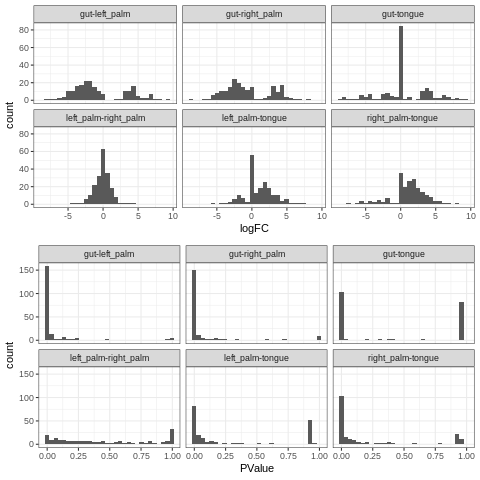

In [ ]:
%%R
# Let's see how edgeR compares/overlaps
Group = get_variable(physeq1, grouping)
design = model.matrix(~ 0 + Group)
dge = as(otu_table(physeq1), "matrix") + 1L
taxonomy = data.frame(as.data.frame(tax_table(physeq1)), "matrix")
dge = DGEList(counts = dge, group = Group, genes = taxonomy, remove.zeros = TRUE)
dge = calcNormFactors(dge, method="RLE")
dge = estimateGLMCommonDisp(dge, design)
dge = estimateGLMTrendedDisp(dge, design)
dge = estimateGLMTagwiseDisp(dge, design)
fit <- glmFit(dge, design)

levels = c(unique(metadata[,grouping]))
comparisons = combn(levels,2, simplify = FALSE)

resEdgeRall <- data.frame()

for (i in comparisons){
  myargs = list(
  paste0(paste0("Group", i[1]), "-" ,paste0("Group", i[2])),
  levels = design)
  my.contrasts <- do.call(makeContrasts, myargs)
  lrt <- glmLRT(fit, contrast = my.contrasts) #fit the model
  resEdgeR = topTags(lrt, n = nrow(dge), adjust.method="BH", sort.by="PValue") #correct pvalue with BH
  resEdgeR = resEdgeR@.Data[[1]]
  resEdgeR <- rownames_to_column(resEdgeR, "ASV")
  resEdgeR$log10p <- -(log10(resEdgeR$PValue))
  resEdgeR$contrast <- paste0(as.character(i[1]),"-", as.character(i[2]))
  resEdgeRall <- rbind(resEdgeRall, resEdgeR)
}

resEdgeRall <- resEdgeRall[!duplicated(resEdgeRall),]
resEdgeRallsig <- resEdgeRall[which(resEdgeRall$FDR <= 0.01), ]

p2 <- ggplot(resEdgeRall, aes(x=logFC)) + geom_histogram() + facet_wrap(~ resEdgeRall$contrast, ncol = 3)
p3 <- ggplot(resEdgeRall, aes(x=PValue)) + geom_histogram() + facet_wrap(~ resEdgeRall$contrast, ncol = 3)

plotGrob <- plot_grid(p2, p3, nrow=2, ncol=1, byrow=FALSE)
print(plot_grid(plotGrob, nrow=1, ncol=1, rel_heights=c(1, 25)))

#### Combined DESeq2 and EdgeR results.

</br>
How much do the two analyses overlap?
</br>

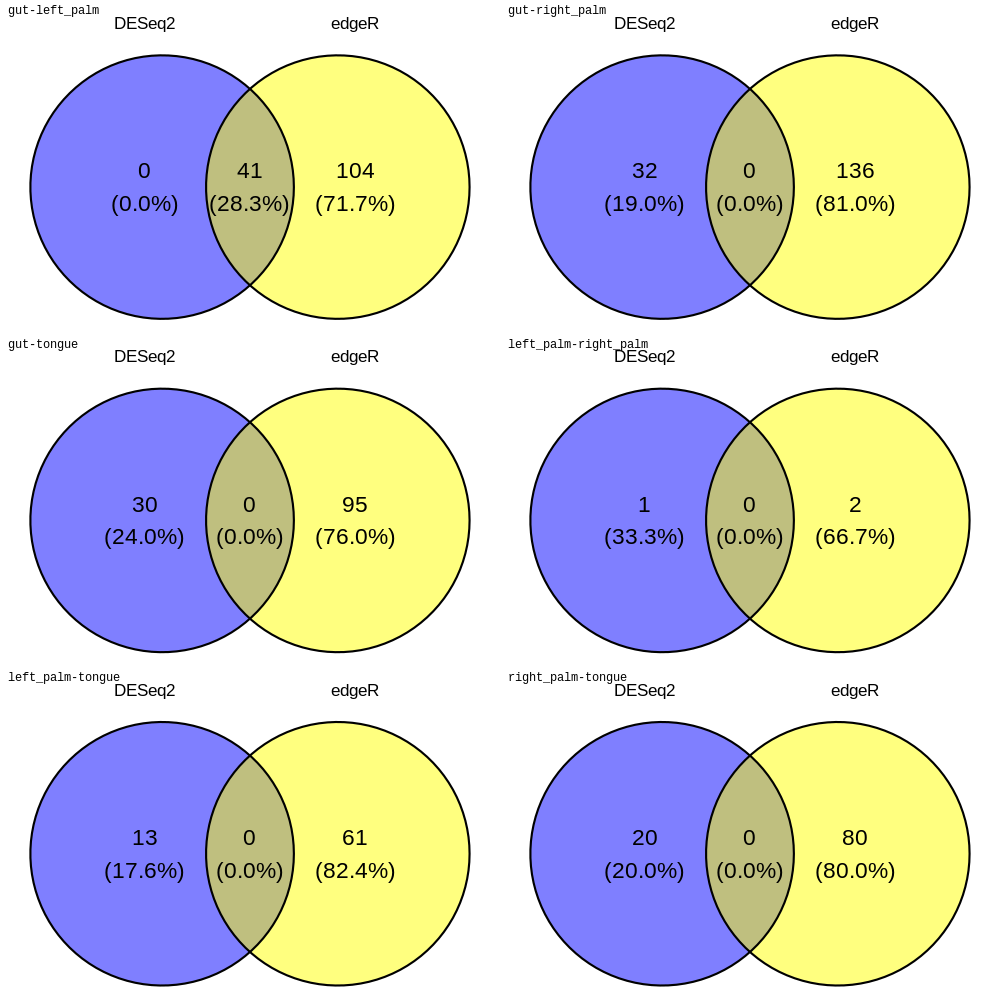

In [ ]:
%%R -h 1000 -w 1000
ggs <- lapply(sort(unique(sigtab$contrast)), function(crb) {
  ggvenn::ggvenn(data = list("DESeq2" = rownames(filter(sigtab, contrast == crb)), "edgeR" = filter(resEdgeRallsig, contrast == crb)$ASV), text_size = 8) + theme(text = element_text(size=10,  family="Comic Sans MS")) + ggtitle(crb)
})

if (length(comparisons) > 1) {
  print(ggarrange(plotlist = ggs, nrow=(length(comparisons)/2), ncol=2))
} else {
   print(ggarrange(plotlist = ggs, nrow=1, ncol=1))
}


</br>

- Scatter plots showing the significant (p less than 0.01) log2 fold change in abundance of different taxa between the reference group and sample group. If sample groups are missing, that means there are no significant differentially abundant taxa between them.  

- Volcano plots showing under- (negative log fold change) and over- (positive log fold change) represented taxa between reference group and sample group. Only the taxa shared between EdgeR and DESeq2 analysis are marked in red and labelled (if Genus information available)

The results are interpreted as (refgroup-samplegroup): negative log fold change means its higher in sample group than reference group (under-represented in reference group), positive log fold change - lower in sample group than in reference group (over-represented in refence group).


</br>

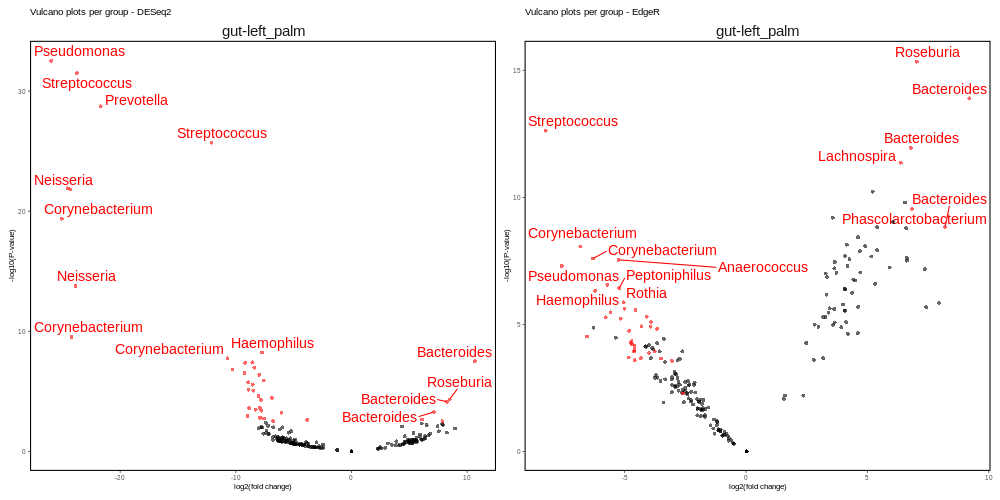

In [ ]:
%%R -h 500 -w 1000
theme_set(theme_bw())
scale_fill_discrete <- function(palname = "Set1", ...) {
  scale_fill_brewer(palette = palname, ...)
}

res_deseq_edger_sig = data.frame()
for (i in unique(sigtab$contrast)) {
  df = filter(sigtab[sigtab$contrast == i,], rownames(sigtab[sigtab$contrast == i,]) %in% resEdgeRallsig[resEdgeRallsig$contrast == i,]$ASV)
  res_deseq_edger_sig=rbind(res_deseq_edger_sig, df)
}


#plot
ggplot(res_deseq_edger_sig, aes(x=Genus, y=log2FoldChange, color=Phylum)) + geom_point(size=3) + facet_wrap(~ res_deseq_edger_sig$contrast, ncol = 3) +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5)) + ggtitle("Plots per group")

#reses <- reses %>% mutate(Significant=if_else(reses$padj < 0.01, TRUE, FALSE)) %>%
#  mutate(TaxonToPrint=if_else(reses$padj < 0.01, as.character(Genus), ""))

res_deseq_edger = data.frame()
for (i in unique(reses$contrast)) {
  df = filter(reses[reses$contrast == i,], rownames(reses[reses$contrast == i,]) %in% resEdgeRall[resEdgeRall$contrast == i,]$ASV)
  res_deseq_edger=rbind(res_deseq_edger, df)
}

res_deseq_edger <- res_deseq_edger %>% mutate(Significant=if_else(rownames(res_deseq_edger) %in% rownames(res_deseq_edger_sig), TRUE, FALSE)) %>%
  mutate(TaxonToPrint=if_else(rownames(res_deseq_edger) %in% rownames(res_deseq_edger_sig), as.character(Genus), ""))


p1 <- ggplot(res_deseq_edger, aes(x=log2FoldChange, y=log10p, color=Significant, label=TaxonToPrint)) +
  geom_text_repel(size=5, nudge_y=0.05) +
  geom_point(alpha=0.6, shape=16) +
  theme_q2r() +
  facet_wrap(~ res_deseq_edger$contrast, ncol = 3) +
  xlab("log2(fold change)") +
  ylab("-log10(P-value)") +
  theme(legend.position="none", strip.text = element_text(size=15)) +
  scale_color_manual(values=c("black","red")) + ggtitle("Vulcano plots per group - DESeq2")

res_deseq_edger = data.frame()
for (i in unique(reses$contrast)) {
    df = filter(resEdgeRall[resEdgeRall$contrast == i,], resEdgeRall[resEdgeRall$contrast == i,]$ASV %in% rownames(reses[reses$contrast == i,]))
    res_deseq_edger=rbind(res_deseq_edger, df)
}

res_deseq_edger <- res_deseq_edger %>% mutate(Significant=if_else(res_deseq_edger$ASV %in% rownames(res_deseq_edger_sig), TRUE, FALSE)) %>%
    mutate(TaxonToPrint=if_else(res_deseq_edger$ASV %in% rownames(res_deseq_edger_sig), as.character(Genus), ""))


p2 <- ggplot(res_deseq_edger, aes(x=logFC, y=log10p, color=Significant, label=TaxonToPrint)) +
    geom_text_repel(size=5, nudge_y=0.05) +
    geom_point(alpha=0.6, shape=16) +
    theme_q2r() +
    facet_wrap(~ res_deseq_edger$contrast, ncol = 3) +
    xlab("log2(fold change)") +
    ylab("-log10(P-value)") +
    theme(legend.position="none", strip.text = element_text(size=15)) +
    scale_color_manual(values=c("black","red")) + ggtitle("Vulcano plots per group - EdgeR")

p1 + p2